In [17]:
#load packages
import os, sys, cv2, re, itertools,time
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
from PyQt5 import QtWidgets, QtGui
from PyQt5.uic import loadUi
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
from customised_functions import *  #import my customised functions

In [14]:
#Red-channel only

#Data preparation
##load dataframe prepared 
train_folder = "C:/Users/folia/metar_project/images/filtered/filtered_train_cropped"
df = pd.read_excel("C:/Users/folia/metar_project/images/filtered/filtered_train_cropped/filtered_train.xlsx")
df = df.sample(frac=1) #random shuffle for dataframe, just to cut off smilarities between "windows" and let model learn more complex patterns

#First, training dataset
img_list_train = []       #create a list of image arrays

#Read images into an array, and calculate mean value of every channel of each photo
for name in df['window_name']:
    #Read images
    temp = cv2.imread(os.path.join(train_folder, name))
    img_list_train.append(temp)

img_list_train = np.array(img_list_train,dtype="float32")/255.0 #normalise
newshape = (*img_list_train.shape[0:3],1)   #add 1 to the tuple as the fourth dimension
img_list_train_R = img_list_train[:,:,:,2].reshape(newshape) #slice and reshape
del temp


#Second, test data
df_test = pd.read_excel("C:/Users/folia/metar_project/images/filtered/filtered_test_cropped/filtered_test.xlsx")
test_folder = "C:/Users/folia/metar_project/images/filtered/filtered_test_cropped"
img_list_test = []
for name in df_test['window_name']:
    temp = cv2.imread(os.path.join(test_folder, name))
    img_list_test.append(temp)

img_list_test = np.array(img_list_test,dtype="float32")/255.0 #normalise
newshape = (*img_list_test.shape[0:3],1) #add 1 to the tuple as the fourth dimension
img_list_test_R = img_list_test[:,:,:,2].reshape(newshape) #slice and reshape
del temp

#Check tensor shape
print(f" Shape of train set is {img_list_train.shape} \n Shape of test set is {img_list_test.shape}")

Shape of train set is (340, 149, 99, 3) 
shape of test set is (178, 149, 99, 3)


In [15]:
##build convnet for only one input (photos) regression using functional API 
inputs = keras.Input(shape=(149,99,1),name = "window_input") #Change tensor shape to just 1 channel
hidden_layers = layers.Conv2D(filters = 32, kernel_size = 5, activation = "relu")(inputs)
hidden_layers = layers.MaxPooling2D(pool_size=3)(hidden_layers)
hidden_layers = layers.Conv2D(filters = 64, kernel_size = 5, activation = "relu")(hidden_layers)
hidden_layers = layers.MaxPooling2D(pool_size=3)(hidden_layers)
hidden_layers = layers.Flatten()(hidden_layers)
hidden_layers = layers.Dense(256,activation = "relu")(hidden_layers)
outputs = layers.Dense(1,activation = "linear")(hidden_layers) #for regression purpose, adapt "linear" activation method

model4 = keras.Model(inputs = inputs, outputs = outputs)
model4.summary()
model4.compile(loss = "mean_squared_error", optimizer = "adam")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 window_input (InputLayer)   [(None, 149, 99, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 145, 95, 32)       832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 27, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 9, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8064)              0     

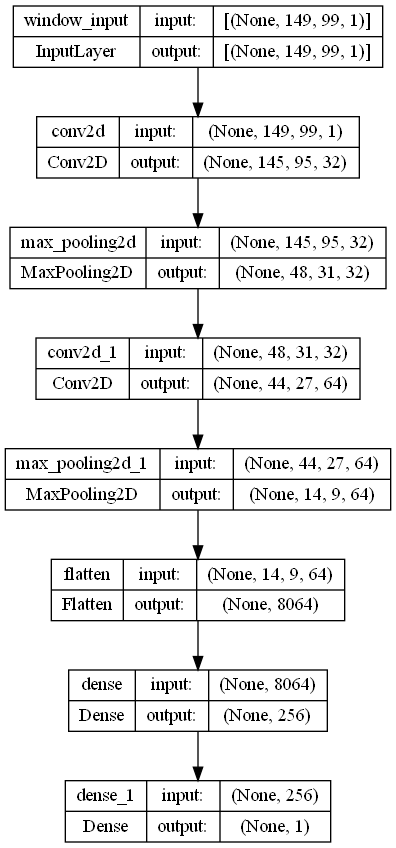

In [19]:
#Plot the structure of whole model
plot_model(model4, show_shapes=True, show_layer_names=True)

In [20]:
#Fit the data into model
history4 = model4.fit(x=img_list_train_R, y=df['cloud_height'],batch_size=32,epochs=10,
          validation_split=0.2)

Epoch 1/10
9/9 [==============================] - 7s 695ms/step - loss: 10463.6758 - val_loss: 8489.2969
Epoch 2/10
9/9 [==============================] - 6s 703ms/step - loss: 7631.0718 - val_loss: 8115.2812
Epoch 3/10
9/9 [==============================] - 6s 660ms/step - loss: 7177.9204 - val_loss: 7722.7041
Epoch 4/10
9/9 [==============================] - 6s 737ms/step - loss: 7212.1729 - val_loss: 7399.2544
Epoch 5/10
9/9 [==============================] - 6s 718ms/step - loss: 6819.4854 - val_loss: 7031.1440
Epoch 6/10
9/9 [==============================] - 6s 685ms/step - loss: 6537.4932 - val_loss: 6653.3711
Epoch 7/10
9/9 [==============================] - 6s 652ms/step - loss: 6116.8018 - val_loss: 6213.8291
Epoch 8/10
9/9 [==============================] - 6s 647ms/step - loss: 5608.0947 - val_loss: 5442.6133
Epoch 9/10
9/9 [==============================] - 6s 669ms/step - loss: 4631.4229 - val_loss: 4378.8345
Epoch 10/10
9/9 [==============================] - 6s 687ms/ste

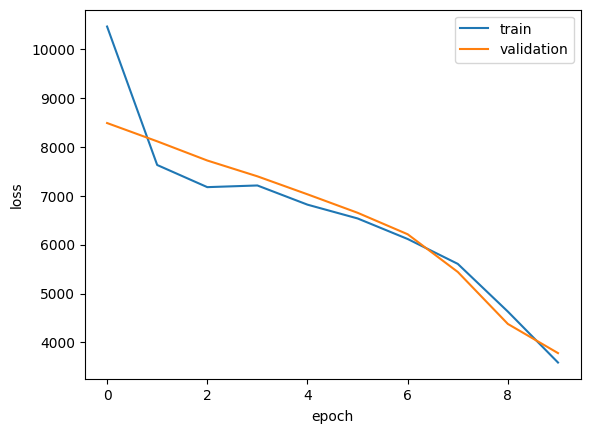

In [21]:
#Plot training history
regression_history_plot(history4)

In [30]:
#evaluate the regression model

#make predictions using model trained
start_time = time.time()
pred = model4.predict(x=img_list_test_R, steps = len(df_test)) #return a 1D array consist of predicted values
cloud_height_pred = pred.flatten().astype(int) #remove fractions
end_time = time.time()

print(f"R-channel only model spent {end_time-start_time} seconds for predicting")

###write the predicted values into a csv file
df_pred_result4 = pd.DataFrame({"window_name":df_test['window_name'], "y_pred":cloud_height_pred, "y_true":df_test["cloud_height"]})
df_pred_result4.to_csv(os.path.join(test_folder,"predicts4.csv"))

178/178 [==============================] - 1s 8ms/step
R-channel only model spent 1.6697452068328857 seconds for predicting


The Mean square error of model 4 is 4783.039
Check the 10 largest error are 
                  window_name  y_pred  y_true  pred_error
171           6-IR-N_1_7.jpg      58     200         142
152          21-IR-N_1_6.jpg      59     200         141
153          21-IR-N_1_7.jpg      60     200         140
151          21-IR-N_1_5.jpg      60     200         140
170           6-IR-N_1_6.jpg      60     200         140
177           6-IR-N_2_7.jpg      63     200         137
68   1310-HDR_normal_2_4.jpg      63     200         137
59   1310-HDR_normal_1_3.jpg      65     200         135
66   1310-HDR_normal_2_2.jpg      67     200         133
67   1310-HDR_normal_2_3.jpg      68     200         132


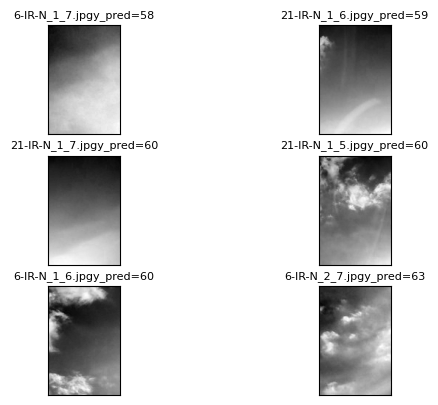

'\nAlthough the overall loss has slightly decreased, the predicting performence is worse than the original model.\nPossible causes:\n1.Not sufficient info. in data: Auto exposure setting aims to achieve a "balanced gray 5" image. \nThus, although the camera is able to capture infrared light, but the R light was recorded in an overall density value.\nIn this scenario, the device is not able to distinguish light of high cloud from low level cloud.\n2.In addition to point 1, I do not have enough obs. My target value are mostly middle level cloud, which was the model learned.\nTherefore, the model trained tends to predict "middle" value to decrease the overall loss. In other words, unbalancd weights'

In [28]:
#Examinate the first result

#1. calculate MSE
model4_mse = np.square(np.subtract(df_pred_result4['y_true'],df_pred_result4['y_pred'])).mean() #MSE = (1/n)*Sigma(y_true-y_pred)^2
print(f'The Mean square error of model 4 is {round(model4_mse,3)}')

#2. check 10 images of largest prediction error
df_pred_result4['pred_error'] = np.subtract(df_pred_result4['y_true'],df_pred_result4['y_pred']).abs()
df_pred_result4.sort_values("pred_error",axis = 0, ascending =False, inplace =True)
print("Check the 10 largest error are \n",df_pred_result4[0:10])


index = df_pred_result4.index
for i in range(6):
    j = index[i] #a short-handed index for shuffled DF
    img = cv2.imread(os.path.join(test_folder,df_pred_result4['window_name'][j]))
    plt.subplot(3,2,i+1)
    plt.imshow(img[:,:,2],cmap='gray')  #plot out R channel
    plt.title(df_pred_result4['window_name'][j]+"y_pred="+str(df_pred_result4['y_pred'][j]),fontsize=8)
    plt.xticks([])
    plt.yticks([])
plt.show()

'''
Although the overall loss has slightly decreased, the predicting performence is worse than the original model.
Possible causes:
1.Not sufficient info. in data: Auto exposure setting aims to achieve a "balanced gray 5" image. 
Thus, although the camera is able to capture infrared light, but the R light was recorded in an overall density value.
In this scenario, the device is not able to distinguish light of high cloud from low level cloud.
2.In addition to point 1, I do not have enough obs. My target value are mostly middle level cloud, which was the model learned.
Therefore, the model trained tends to predict "middle" value to decrease the overall loss. In other words, unbalancd weights'''